In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [2]:
from google.colab import files

uploaded = files.upload()

Saving orders_and_shipments_final_cleaned.csv to orders_and_shipments_final_cleaned.csv


In [5]:
# leading the data
df = pd.read_csv("orders_and_shipments_final_cleaned.csv")
print(df.head())

  Order Time  Order Quantity Product Department Product Category  \
0      14:07               1           Fan Shop          Fishing   
1       7:37               1           Fan Shop          Fishing   
2      22:47               1           Fan Shop          Fishing   
3      22:32               1           Fan Shop          Fishing   
4      22:32               1           Fan Shop          Fishing   

                                Product Name Customer Market  Customer Region  \
0  Field & Stream Sportsman 16 Gun Fire Safe           LATAM  Central America   
1  Field & Stream Sportsman 16 Gun Fire Safe           LATAM    South America   
2  Field & Stream Sportsman 16 Gun Fire Safe           LATAM  Central America   
3  Field & Stream Sportsman 16 Gun Fire Safe          Europe  Northern Europe   
4  Field & Stream Sportsman 16 Gun Fire Safe          Europe  Northern Europe   

  Customer Country Warehouse Country   Shipment Mode  \
0           Mexico       Puerto Rico  Standard C

In [13]:


# Convert dates to datetime
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Shipment Date"] = pd.to_datetime(df["Shipment Date"])

# Calculate actual shipment days
df["Actual Shipment Days"] = (df["Shipment Date"] - df["Order Date"]).dt.days

# Calculate delay
df["Delay"] = df["Actual Shipment Days"] - df["Shipment Days - Scheduled"]


In [14]:
df.columns


Index(['Order Time', 'Order Quantity', 'Product Department',
       'Product Category', 'Product Name', 'Customer Market',
       'Customer Region', 'Customer Country', 'Warehouse Country',
       'Shipment Mode', 'Shipment Days - Scheduled', 'Order Date',
       'Shipment Date', 'Region', 'Actual Shipment Days', 'Delay'],
      dtype='object')

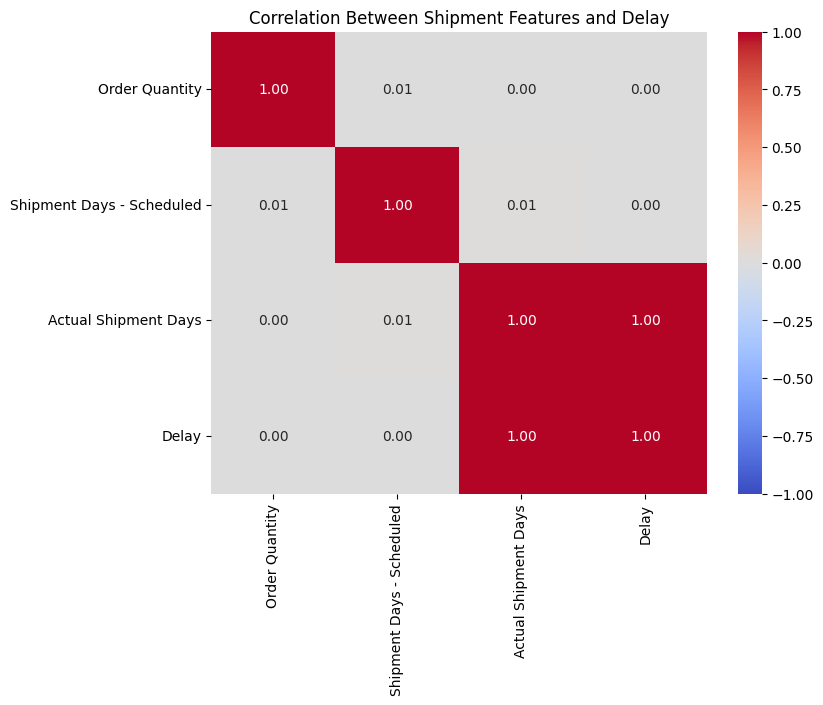


=== Correlation Matrix ===
                           Order Quantity  Shipment Days - Scheduled  \
Order Quantity                   1.000000                   0.007612   
Shipment Days - Scheduled        0.007612                   1.000000   
Actual Shipment Days             0.003390                   0.013051   
Delay                            0.003322                   0.004024   

                           Actual Shipment Days     Delay  
Order Quantity                         0.003390  0.003322  
Shipment Days - Scheduled              0.013051  0.004024  
Actual Shipment Days                   1.000000  0.999959  
Delay                                  0.999959  1.000000  


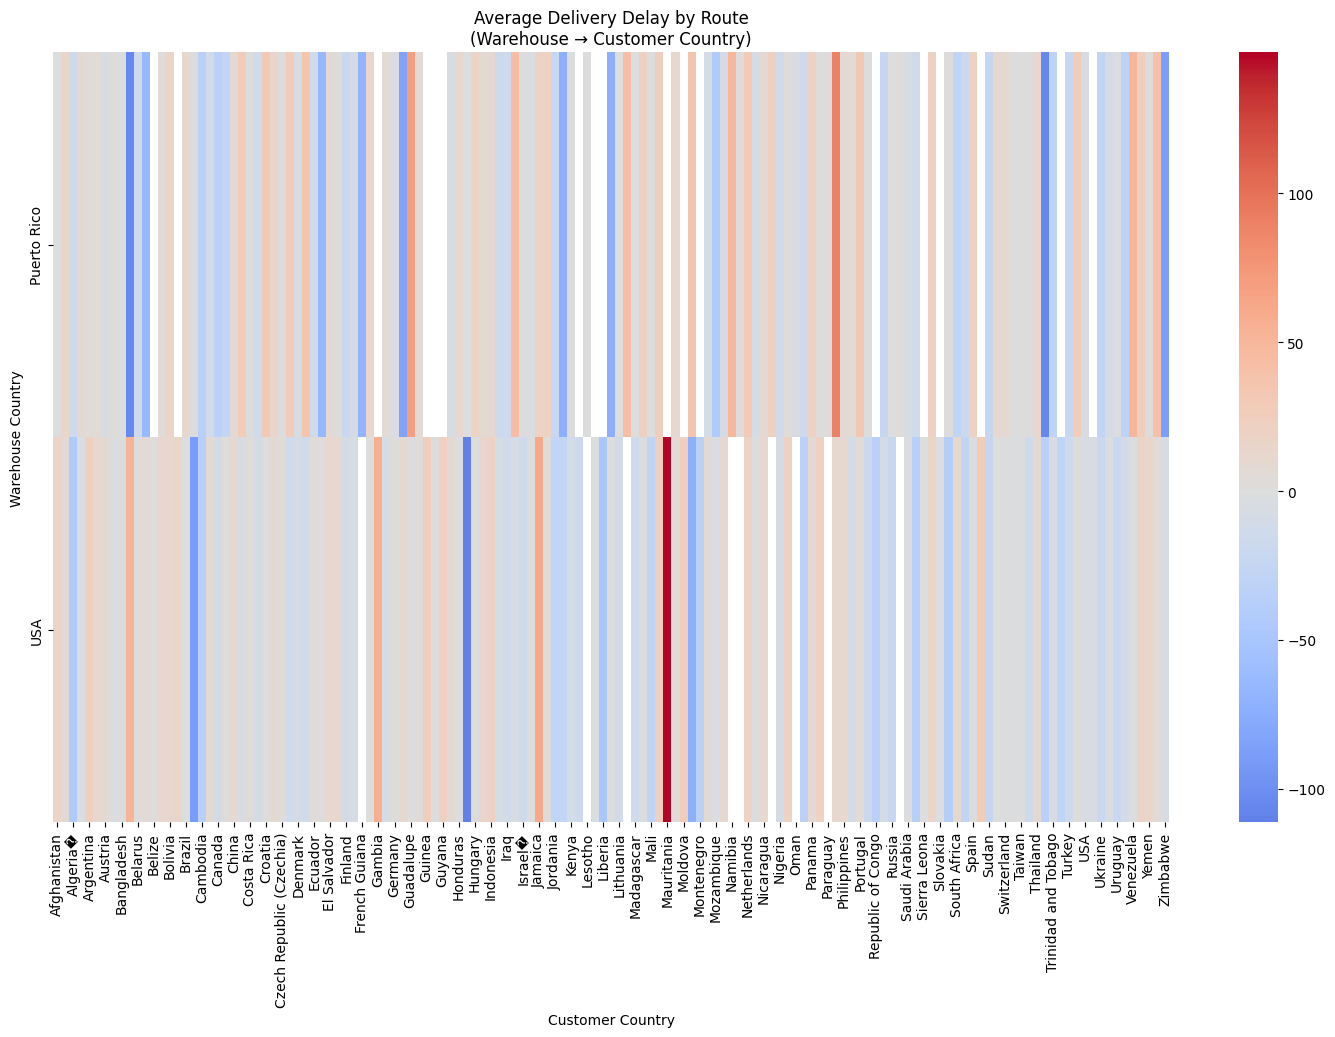


=== Top 15 Most Delayed Routes ===
Warehouse Country  Customer Country  
USA                Mauritania            147.400000
Puerto Rico        Peru                   89.886364
                   Guadalupe              69.000000
USA                Jamaica                61.750000
                   Gambia                 56.600000
                   Barbados               53.785714
Puerto Rico        Venezuela              51.318182
                   Namibia                50.000000
                   Ireland                44.781250
                   Macedonia              43.000000
                   Zambia                 40.166667
                   Dominican Republic     36.322275
                   Mongolia               35.500000
                   Portugal               33.200000
                   Croatia                31.666667
Name: Delay, dtype: float64


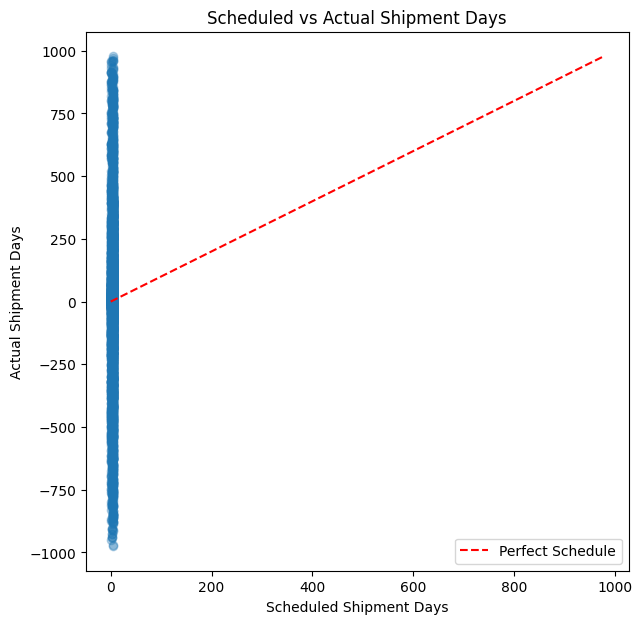

In [16]:

import plotly.express as px


# Make sure dates are datetime
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Shipment Date"] = pd.to_datetime(df["Shipment Date"])

# -----------------------------------------
# 1. CORRELATION HEATMAP
# -----------------------------------------

numeric_cols = [
    "Order Quantity",
    "Shipment Days - Scheduled",
    "Actual Shipment Days",
    "Delay"
]

corr_data = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_data, annot=True, cmap="coolwarm", fmt=".2f",
            vmin=-1, vmax=1)
plt.title("Correlation Between Shipment Features and Delay")
plt.show()

print("\n=== Correlation Matrix ===")
print(corr_data)

# -----------------------------------------
# 2. ROUTE-LEVEL HEATMAP (Warehouse → Customer Country)
# -----------------------------------------

route_pivot = df.pivot_table(
    index="Warehouse Country",
    columns="Customer Country",
    values="Delay",
    aggfunc="mean"
)

plt.figure(figsize=(18, 10))
sns.heatmap(route_pivot, cmap="coolwarm", center=0)
plt.title("Average Delivery Delay by Route\n(Warehouse → Customer Country)")
plt.xlabel("Customer Country")
plt.ylabel("Warehouse Country")
plt.show()

print("\n=== Top 15 Most Delayed Routes ===")
print(
    df.groupby(["Warehouse Country", "Customer Country"])["Delay"]
      .mean()
      .sort_values(ascending=False)
      .head(15)
)

# -----------------------------------------
# 3. WORLD MAP OF AVERAGE DELAY
# -----------------------------------------

country_delay = (
    df.groupby("Customer Country")["Delay"]
      .mean()
      .reset_index()
      .rename(columns={"Delay": "Avg Delay Days"})
)

fig = px.choropleth(
    country_delay,
    locations="Customer Country",
    locationmode="country names",
    color="Avg Delay Days",
    color_continuous_scale="RdBu_r",
    title="Average Delivery Delay by Customer Country",
    labels={"Avg Delay Days": "Avg Delay (days)"}
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True)
)

fig.show()

# -----------------------------------------
# 4. SCHEDULED VS ACTUAL SHIPMENT DAYS
# -----------------------------------------

plt.figure(figsize=(7, 7))
plt.scatter(
    df["Shipment Days - Scheduled"],
    df["Actual Shipment Days"],
    alpha=0.3
)
max_val = max(
    df["Shipment Days - Scheduled"].max(),
    df["Actual Shipment Days"].max()
)
plt.plot([0, max_val], [0, max_val], "r--", label="Perfect Schedule")
plt.xlabel("Scheduled Shipment Days")
plt.ylabel("Actual Shipment Days")
plt.title("Scheduled vs Actual Shipment Days")
plt.legend()
plt.show()


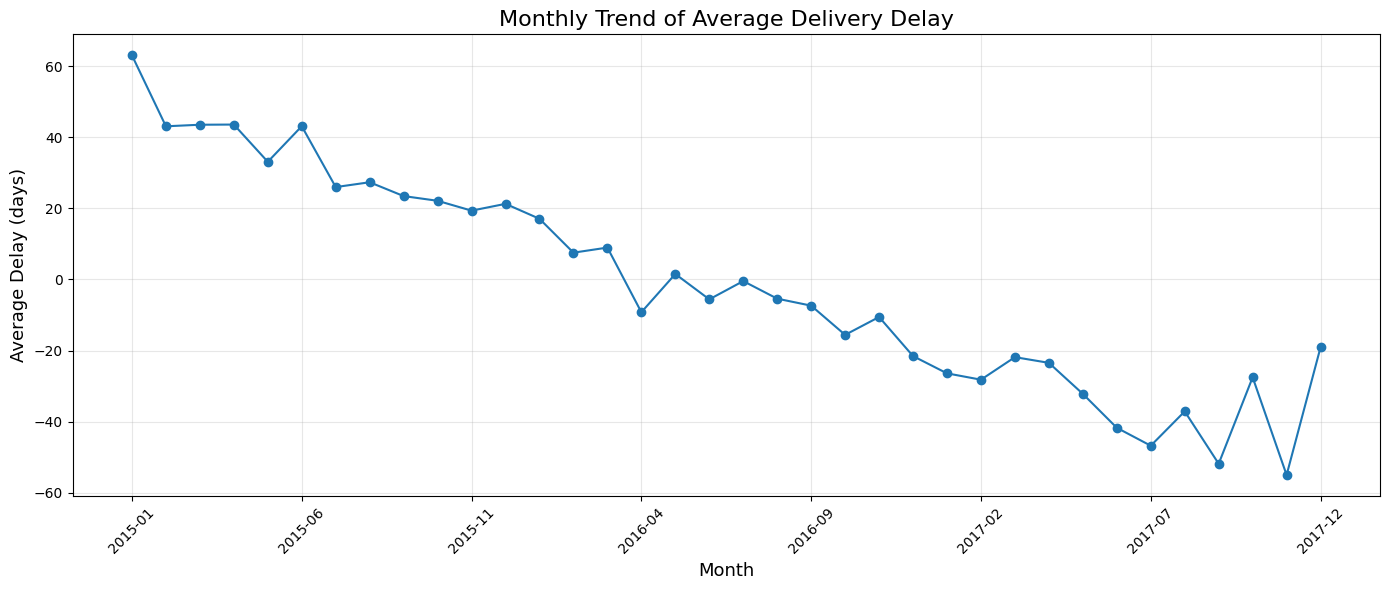

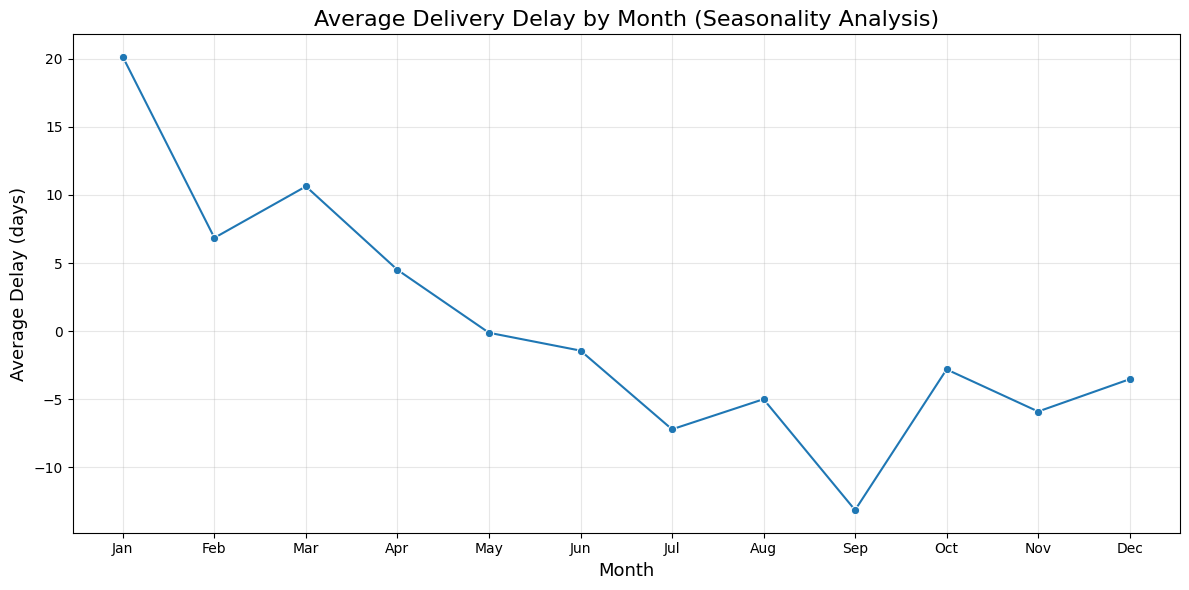

/tmp/ipython-input-362723456.py:53: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




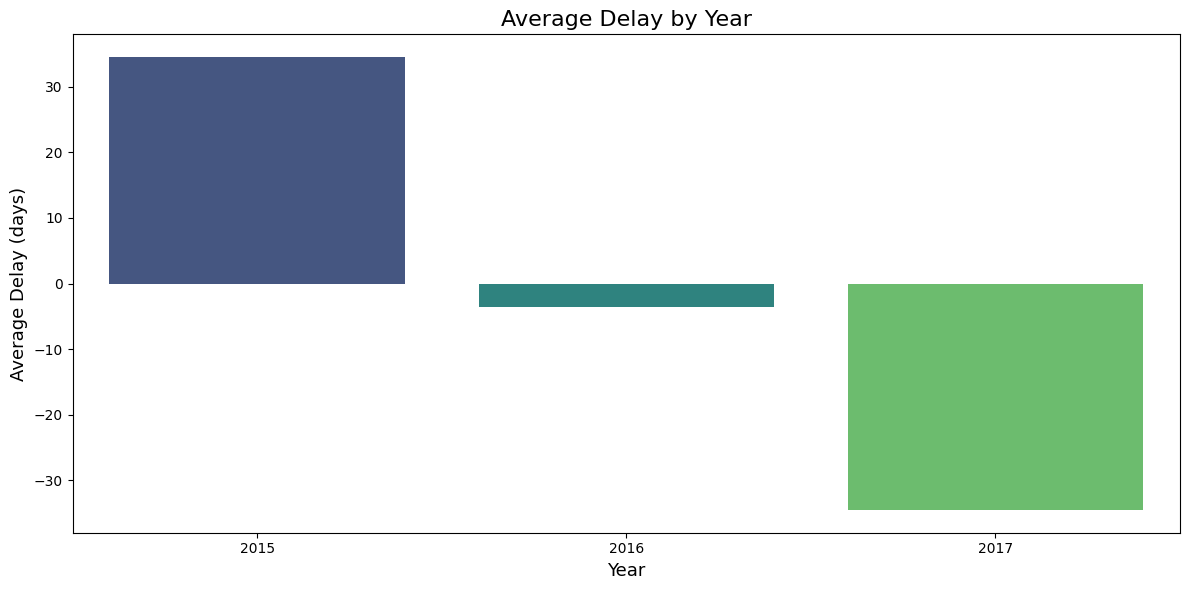

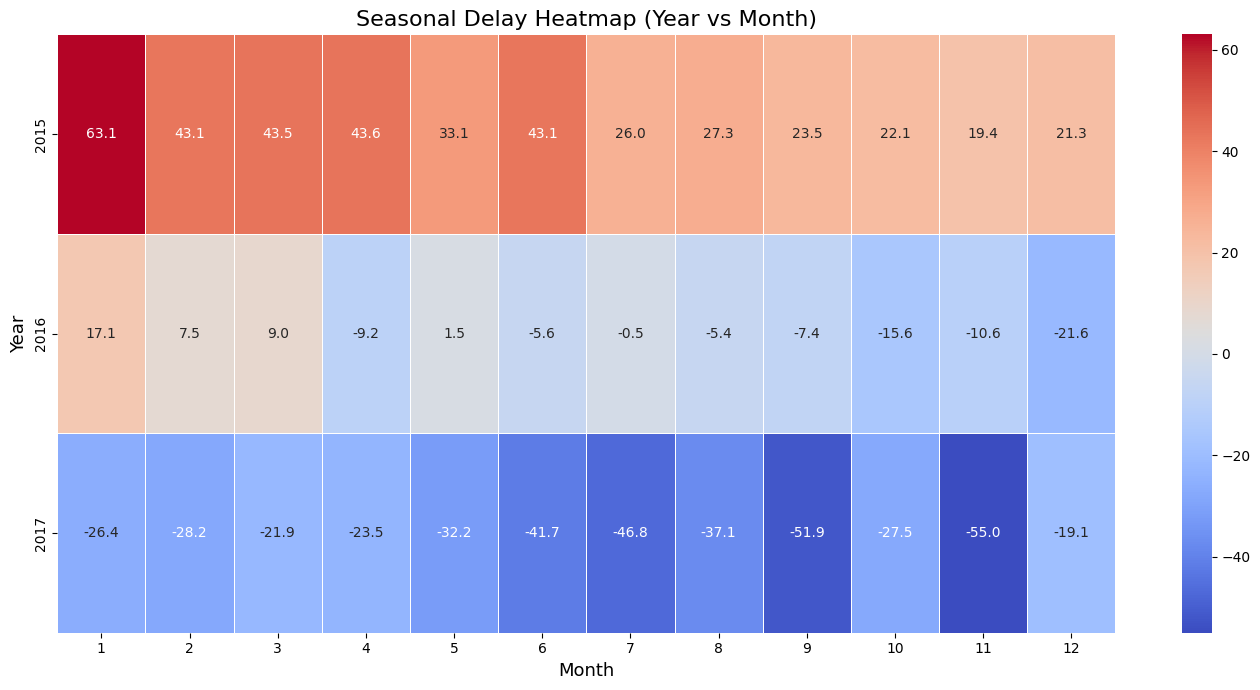

In [18]:


# --- Ensure dates are in datetime format ---
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Shipment Date"] = pd.to_datetime(df["Shipment Date"])

# --- Extract useful time features ---
df["order_year"] = df["Order Date"].dt.year
df["order_month"] = df["Order Date"].dt.month
df["order_month_name"] = df["Order Date"].dt.strftime("%b")
df["order_year_month"] = df["Order Date"].dt.to_period("M").astype(str)

# -----------------------------------------------------
# 1️⃣ MONTHLY AVERAGE DELAY (Trend over entire timeline)
# -----------------------------------------------------

monthly_delay = df.groupby("order_year_month")["Delay"].mean()

plt.figure(figsize=(14, 6))
monthly_delay.plot(marker="o")
plt.title("Monthly Trend of Average Delivery Delay", fontsize=16)
plt.xlabel("Month", fontsize=13)
plt.ylabel("Average Delay (days)", fontsize=13)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 2️⃣ AVERAGE DELAY BY MONTH OF YEAR
#    (Seasonal pattern: Jan, Feb, Mar…)
# -----------------------------------------------------

monthly_seasonal = df.groupby("order_month")["Delay"].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_seasonal.index, y=monthly_seasonal.values, marker="o")
plt.title("Average Delivery Delay by Month (Seasonality Analysis)", fontsize=16)
plt.xlabel("Month", fontsize=13)
plt.ylabel("Average Delay (days)", fontsize=13)
plt.xticks(range(1, 13),
           ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 3️⃣ AVERAGE DELAY BY YEAR
#    (Is the supply chain improving or getting worse?)
# -----------------------------------------------------

yearly_delay = df.groupby("order_year")["Delay"].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=yearly_delay.index, y=yearly_delay.values, palette="viridis")
plt.title("Average Delay by Year", fontsize=16)
plt.xlabel("Year", fontsize=13)
plt.ylabel("Average Delay (days)", fontsize=13)
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 4️⃣ HEATMAP — Month vs Year (Seasonal Matrix)
# -----------------------------------------------------

pivot = df.pivot_table(
    values="Delay",
    index="order_year",
    columns="order_month",
    aggfunc="mean"
)

plt.figure(figsize=(14, 7))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)
plt.title("Seasonal Delay Heatmap (Year vs Month)", fontsize=16)
plt.xlabel("Month", fontsize=13)
plt.ylabel("Year", fontsize=13)
plt.tight_layout()
plt.show()
